# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель работы:** построить модель, которая умеет определять рыночную стоимость автомобиля.

**Ход работы:**
1. Подготовка данных;
2. Обучение моделей;
3. Анализ моделей.

## Подготовка данных

### Обзор данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

Загрузим данные и изучим их.

In [2]:
#чтение и сохранение данных, вывод первых 5 строк
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#вывод информации о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице 354369 объектов, 15 признаков и 1 целевой признак.
**Признаки:**
* `DateCrawled` — дата скачивания анкеты из базы;
* `VehicleType` — тип автомобильного кузова;
* `RegistrationYear` — год регистрации автомобиля;
* `Gearbox` — тип коробки передач;
* `Power` — мощность (л. с.);
* `Model` — модель автомобиля;
* `Kilometer` — пробег (км);
* `RegistrationMonth` — месяц регистрации автомобиля;
* `FuelType` — тип топлива;
* `Brand` — марка автомобиля;
* `NotRepaired` — была машина в ремонте или нет;
* `DateCreated` — дата создания анкеты;
* `NumberOfPictures` — количество фотографий автомобиля;
* `PostalCode` — почтовый индекс владельца анкеты (пользователя);
* `LastSeen` — дата последней активности пользователя.

**Целевой признак:**
* `Price` — цена (евро).

Пропуски имеются для признаков `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`.


Оценим примерную дату выгрузки данных.

In [4]:
data['DateCreated'].max()

'2016-04-07 00:00:00'

### Удаление дубликатов

Проверим данные на наличие дубликатов.

In [5]:
#количество дубликатов
data.duplicated().sum()

4

Удалим дубликаты из таблицы.

In [6]:
#удаляем дубликаты
data = data.drop_duplicates()

### Удаление неинформативных признаков

Среди признаков есть такие, которые вряд ли влияют на цену автомобиля: 
* дата скачивания анкеты из базы `DateCrawled`;
* месяц регистрации автомобиля `RegistrationMonth`;
* дата создания анкеты `DateCreated`;
* количество фотографий автомобиля `NumberOfPictures`;
* почтовый индекс владельца анкеты (пользователя) `PostalCode`;
* дата последней активности пользователя `LastSeen`.

Удалим эти признаки.

In [7]:
#удаление неинформативных признаков
data = data.drop(['DateCrawled',
                  'RegistrationMonth',
                  'DateCreated',
                  'NumberOfPictures',
                  'PostalCode', 
                  'LastSeen'], axis=1)

### Обработка пропущенных значений

Обработаем пропуски. Оценим количество пропусков для признака `Model`.

In [8]:
len(data[data['Model'].isna()]) / len(data)

0.05560650741467131

Модель автомобиля достаточно важна для ценообразования, и пропущенных данных всего 5.56%, так что можем удалить объекты с пропусками.

In [9]:
#удаляем данные с пропусками в Model
data = data.dropna(subset = ['Model']).reset_index(drop=True)

Пропуски в признаках `VehicleType`, `Gearbox`, `FuelType` и `NotRepaired` заполним заглушкой, чтобы не исказить распределения этих признаков.

In [10]:
#заполняем пропуски значением unknown
data[['VehicleType',
      'Gearbox',
      'FuelType',
      'NotRepaired']] = data[['VehicleType',
                              'Gearbox',
                              'FuelType',
                              'NotRepaired']].fillna('unknown')

### Анализ данных

Посмотрим на описательные характеристики числовых данных.

In [11]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,334660.000000,334660.000000,334660.000000,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076
std,4531.457109,69.377633,185.157391,37205.638630
min,0.000000,1000.000000,0.000000,5000.000000
25%,1150.000000,1999.000000,70.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


У признака RegistrationYear можно заметить наличие выбросов, верхняя граница начала выбросов выяснена выше - 2016 год, построим диаграмму размаха и найдем нижнюю границу.

<AxesSubplot:>

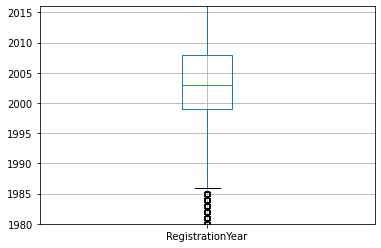

In [12]:
plt.ylim(1980, 2016)
data.boxplot('RegistrationYear')

Удалим аномальные значения более 2016 и менее 1987.

In [13]:
#удаляем значения года более 2022
data = data[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1987)]

Построим тепловую карту коэффициентов корреляции Пирсона для числовых признаков.

<AxesSubplot:>

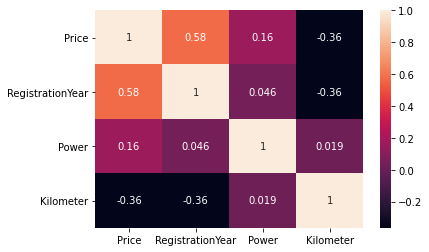

In [14]:
sns.heatmap(data.corr(), annot=True)

Все признаки очень слабо коррелируют между собой.

Посмотрим, как распределен целевой признак.

[Text(0.5, 0, 'Цена')]

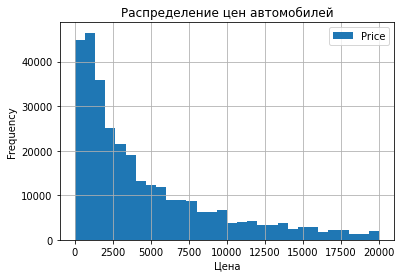

In [15]:
ax = data.plot(kind='hist', 
               y='Price',
               bins=30,
               title='Распределение цен автомобилей',
               grid=True)
ax.set(xlabel='Цена')

### Подготовка выборок

Для начала преобразуем категориальные признаки в числовые при помощи прямого кодирования.

In [16]:
data = pd.get_dummies(data, drop_first=True)

Поделим на обучающую, валидационную и тестовую выборки.

In [17]:
#деление на признаки и целевой признак
X = data.drop('Price', axis=1)
y = data['Price']

#деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

#проверяем размеры выборок
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(237608, 306) (237608,)
(79203, 306) (79203,)


Приведем числовые признаки к одному масштабу при помощи стандартизации.

In [18]:
#выделяем числовые признаки
numeric = ['RegistrationYear', 'Power', 'Kilometer']

#стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

/tmp/ipykernel_196/1410968605.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric] = scaler.transform(X_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_196/1410968605.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

## Обучение моделей

### Дерево решений

In [19]:
model_dt = DecisionTreeRegressor(random_state=12345)

param = {'max_depth': range(1,21,1)}
grid = RandomizedSearchCV(model_dt, param, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
best_model_dt = grid.best_estimator_
rmse_dt = abs(grid.best_score_)
print('RMSE:', rmse_dt, 'Параметры:', grid.best_params_)

RMSE: 1882.6462512039732 Параметры: {'max_depth': 16}


### Случайный лес

In [20]:
model_rf = RandomForestRegressor(random_state=12345)

param = {'max_depth': range(1,11,1),
         'n_estimators':range(10,50,10)}
grid = RandomizedSearchCV(model_rf, param, n_iter=10, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
best_model_rf = grid.best_estimator_
rmse_rf = abs(grid.best_score_)
print('RMSE:', rmse_rf, 'Параметры:', grid.best_params_)

RMSE: 1915.6086617615733 Параметры: {'n_estimators': 40, 'max_depth': 10}


### CatBoost

In [21]:
model_cb = CatBoostRegressor(random_state=12345)

param = {'depth': range(1,15,1),
         'iterations': range(10,100,10)}
grid = RandomizedSearchCV(model_cb, param, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train, verbose=10)
best_model_cb = grid.best_estimator_
rmse_cb = abs(grid.best_score_)
print('RMSE:', rmse_cb, 'Параметры:', grid.best_params_)

Learning rate set to 0.5
0:	learn: 3110.2379816	total: 95ms	remaining: 6.55s
10:	learn: 1823.3550462	total: 475ms	remaining: 2.55s
20:	learn: 1737.4495972	total: 835ms	remaining: 1.95s
30:	learn: 1686.1008719	total: 1.19s	remaining: 1.49s
40:	learn: 1654.3458374	total: 1.53s	remaining: 1.08s
50:	learn: 1619.8350510	total: 1.89s	remaining: 704ms
60:	learn: 1598.7354334	total: 2.27s	remaining: 335ms
69:	learn: 1582.2679191	total: 2.58s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3100.4962101	total: 38.2ms	remaining: 2.64s
10:	learn: 1815.0446933	total: 400ms	remaining: 2.15s
20:	learn: 1734.6327370	total: 762ms	remaining: 1.78s
30:	learn: 1684.8621065	total: 1.12s	remaining: 1.41s
40:	learn: 1645.8756354	total: 1.5s	remaining: 1.06s
50:	learn: 1619.8458105	total: 1.87s	remaining: 697ms
60:	learn: 1596.7169373	total: 2.23s	remaining: 328ms
69:	learn: 1579.4772584	total: 2.55s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3100.0801221	total: 38.9ms	remaining: 2.68s
10:	learn: 182

### LightGBM

In [22]:
categorical_features = [col for col in list(X_train.columns) if col not in numeric]

model_lgbm = LGBMRegressor(random_state=12345)
param = {'max_depth': range(1,15,1),
         'n_estimators': range(10,100,10)}
grid = RandomizedSearchCV(model_lgbm, param, n_iter=10, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train, categorical_feature=categorical_features)
best_model_lgbm = grid.best_estimator_
rmse_lgbm = abs(grid.best_score_)
print('RMSE:', rmse_lgbm, 'Параметры:', grid.best_params_)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_fe

RMSE: 1731.3311311526115 Параметры: {'n_estimators': 90, 'max_depth': 8}


## Анализ моделей

Сравним важные для заказчика критерии, соберем время обучения, предсказания и RMSE в одной таблице.

In [23]:
#функция, возвращающая время обучения, предсказания и RMSE модели
def model_param(best_model, rmse):
    start = time.time()
    best_model.fit(X_train, y_train)
    end = time.time()
    fit_time = end - start
    
    start = time.time()
    predict = best_model.predict(X_train)
    end = time.time()
    predict_time = end - start
    
    return round(fit_time, 3), round(predict_time, 3), round(rmse, 3)

In [24]:
res = []
res.append(model_param(best_model_dt, rmse_dt))
res.append(model_param(best_model_rf, rmse_rf))
res.append(model_param(best_model_cb, rmse_cb))
res.append(model_param(best_model_lgbm, rmse_lgbm))

Learning rate set to 0.5
0:	learn: 2966.8308935	total: 365ms	remaining: 28.9s
1:	learn: 2269.3830597	total: 699ms	remaining: 27.3s
2:	learn: 1996.8172983	total: 1.03s	remaining: 26.5s
3:	learn: 1865.5545934	total: 1.38s	remaining: 26.3s
4:	learn: 1812.2243910	total: 1.72s	remaining: 25.7s
5:	learn: 1777.1833203	total: 2.06s	remaining: 25.5s
6:	learn: 1755.8628866	total: 2.38s	remaining: 24.8s
7:	learn: 1736.6611715	total: 2.7s	remaining: 24.3s
8:	learn: 1719.2549677	total: 3.02s	remaining: 23.8s
9:	learn: 1703.9802905	total: 3.37s	remaining: 23.6s
10:	learn: 1693.6118709	total: 3.73s	remaining: 23.4s
11:	learn: 1683.5010203	total: 4.04s	remaining: 22.9s
12:	learn: 1671.3794018	total: 4.36s	remaining: 22.5s
13:	learn: 1661.8869432	total: 4.67s	remaining: 22s
14:	learn: 1651.7338873	total: 4.99s	remaining: 21.6s
15:	learn: 1642.5752781	total: 5.3s	remaining: 21.2s
16:	learn: 1635.9390985	total: 5.63s	remaining: 20.9s
17:	learn: 1626.9898969	total: 5.96s	remaining: 20.5s
18:	learn: 1621.2

In [25]:
pd.DataFrame(data = res,
             index = ['Decision Tree', 'Random Forest', 'CatBoost', 'LightGBM'], 
             columns = ['Время обучения', 'Время предсказания', 'RMSE'])

,Время обучения,Время предсказания,RMSE
Decision Tree,6.690,0.428,1882.646
Random Forest,127.534,1.353,1915.609
CatBoost,27.601,0.253,1606.427
LightGBM,22.324,2.735,1731.331


Самое быстрое время предсказания и самое маленькое RMSE у модели CatBoost, но она усупает по времени обучения дереву решений и LightGBM, тем не менее остановим выбор на модели CatBoost.

Проверим работу модели на тестовой выборке.

In [26]:
predictions = best_model_cb.predict(X_test)
print('RMSE:', mean_squared_error(y_test, predictions)**0.5)

RMSE: 1605.4753088998527


## Вывод

В данной работе были изучены и подготовлены предоставленные данные, обучены 4 различных модели, определяющих цену автомобилей. Опираясь на важные для заказчика критерии (время обучения, время предсказания и качество предсказания), была выбрана лучшая модель - модель CatBoost с параметрами iterations=80, depth=14. Данная модель была проверена на тестовой выборке, результат RMSE на тестовой выборке - 1605.48.